# Imports

In [1]:
import yfinance as yf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import datetime

2024-08-13 09:26:02.167863: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-13 09:26:02.228938: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-13 09:26:02.280739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 09:26:02.334253: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 09:26:02.347965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 09:26:02.427918: I tensorflow/core/platform/cpu_feature_gu

# Constantes

In [2]:

# callbacks
early_stopping = EarlyStopping(monitor="val_loss",
                                min_delta = 0.0001,
                                patience = 8,
                                verbose=1,
                                restore_best_weights = True)

reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss",
                                            patience = 5,
                                            factor = 0.0001,
                                            cooldown = 3,
                                            verbose=1,min_lr = 1e-6)

# Fonctions ( à intégrer ensuite en py)

In [4]:
# fonction pour convertir les données en format de séquence:

def create_dataset(array, pas_temps):
    X = []  
    y = []
    for i in range(array.shape[0]-pas_temps-1):
        a = array[i:(i+pas_temps), 0]              
        X.append(a)                             
        y.append(array[i+pas_temps,0])                
    return np.array(X),np.array(y) 


# Pour un tableau de 100 lignes :

# SI pas =1 #1er on prend les données data[0:1,0], c'est à dire la ligne 1 de la première colonne on les mets dans X, puis on met data[1] dans Y c'est à dire la seconde ligne
# On se sert donc d'une ligne pour prédire la ligne suivante 
# On va jusqu'à prédire la 99eme à l'aide de la ligne 98

# Si pas = 2 : #1er on prend les données data[0:2,0], c'est à dire les lignes 1 et 2 de la première colonne, on injecte dans la première entrée de la liste
# Ensuite on met data[2] dans Y c'est à dire la trosième ligne
# On se sert donc de deux lignes  pour prédire la ligne suivante  
# On va jusqu'à prédire la 99eme ligne avec les deux lignes précédentes (donc l'avant dernière ligne)   
   
# En résumé, le paramètre pas_temps spécifie le nombre de pas de temps passés à utiliser comme entrée pour prédire la sortie. Plus la valeur de pas_temps est grande,
# plus le modèle sera capable de capturer des tendances à long terme dans les données, mais il sera également plus sensible aux variations à court terme. Inversement, une valeur plus
# petite de pas_temps permettra au modèle de réagir plus rapidement aux changements dans les données, mais il sera moins capable de capturer des tendances à long terme.


In [58]:
def build_lstm_model(neurons,input_shape = (None,1), activ_func= "relu", loss='mse', metrics= ['mse'], optimizer='adam'):
    """
    Build LSTM model with a certain number of neurons and then a Dense flayer for regression prediction
    :param neurons: Nb of neurons (int>0)
    :param input_shape: Shape of the Input after sequencing of historical prices
    :param activ_func: activation function
    :param loss: loss function used during training
    :param metrics name: metrics showed during training
    :param optimizer: optimizer used during compiling
    :return: LSTM model
    """
    model = Sequential()
    model.add(LSTM(neurons,input_shape=input_shape,activation=activ_func))  
    model.add(Dense(1))
    model.compile(loss=loss, metrics= metrics, optimizer=optimizer)
    return model

# MAPE Computes the mean absolute percentage error between y_true & y_pred.
#see activ_funt

In [8]:
def normalize_data(df,columns):
    """
    Standardise numerci features of a DataFrame
    :param df: pd.DataFrame
    :columns: list of non used columns for the price prediction, which are removed
    :return: np.Array with standardized values
    """    
    # removal of non useless columns    
    df =df.drop(columns=columns, axis=1)
    
    # recupération de l'index (à voir ensuite si utile)
    df_index = df.index
    
    #tf en tableau numpy
    df_array = np.array(df)
    
    #instanciation du Scaler et normalisation
    scaler=MinMaxScaler(feature_range=(0,1))    
    scaled_data = scaler.fit_transform (df_array)
    
    print("Standardisation effectuée")

    return scaled_data, df_index, scaler, "Normalization"

In [9]:
def prepare_sequential_data(data, pas_temps):
    """
    Create an Array with adequate train and target sequences
    :param pas_temps: number of previous days used for prediction
    :param data: Standardized np.array
    """
    X = []  
    y = []
    for i in range(data.shape[0]-pas_temps-1):
        a = data[i:(i+pas_temps), 0]   
        X.append(a)                             
        y.append(data[i+pas_temps, 0])             
    return np.array(X),np.array(y) 


def make_dataset(data,pas_temps,test_size=0.3):
    """
     Split data into train and test data.
    :param data: Standardized np.array
    :param test_size: fraction size of the test data
    :param pas_temps: number of previous days used for prediction
    :return: np.Array with standardized values
    """
    #Train and test data split
    size = int(len(data)*(1-test_size))
    train_data, test_data = data[:size,:], data[size:,:]
 
    
    #Création des ensembles d'entrainement et de la cible en format de séquence:
    X_train, y_train = prepare_sequential_data(data=train_data,pas_temps=pas_temps)
    X_test, y_test = prepare_sequential_data(data=test_data,pas_temps=pas_temps)
    
    #mise en forme des données pour le réseau LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1],1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
    
    print("Séparation des données effectuée:")        
    
    print(f"X_train shape : {X_train.shape}")
    print(f"X_test shape : {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [63]:
def train_LSTM_model(X_train, y_train, X_test, y_test, neurons, pas_temps, batch_size = 10):
    """
    """ 
    # Enregistrer l'heure de début
    start_time = datetime.datetime.now()
    
    #construction du model
    model = build_lstm_model(neurons=neurons)
    
    #entrainement du modèle
    history = model.fit(X_train, y_train,
                        batch_size= 10,
                        epochs=100, verbose=0,
                        validation_data = [X_test, y_test],
                        callbacks=[reduce_learning_rate, early_stopping])
   
    # Enregistrer l'heure de fin
    end_time = datetime.datetime.now()
    # Calculer la durée
    duration = end_time - start_time
    duration_seconds = duration.total_seconds()
    
    # Afficher la durée
    print(f"Temps passé pour un pas de temps de {pas_temps} jour et un nombre de neurones de {neurons} :", duration_seconds, "secondes")
        
    return history,duration_seconds,model
    

In [12]:
def predict(X_train, y_train, X_test, y_test, scaler,model):
    
    #prédiction et remise à l'échelle X
    train_predict = model.predict(X_train)
    #train_predict_valeurs_reelles = scaler.inverse_transform(train_predict)
    train_predict_valeurs_reelles = train_predict/scaler.scale_[0]
    
    test_predict = model.predict(X_test)
    #test_predict_valeurs_reelles = scaler.inverse_transform(test_predict)
    test_predict_valeurs_reelles = test_predict/scaler.scale_[0]
    
    #prédiction et remise à l'échelle y
    y_train = y_train.reshape(-1,1)
    #y_train_valeurs_reelles = scaler.inverse_transform(y_train)
    y_train_valeurs_reelles = y_train /scaler.scale_[0]
    
    y_test = y_test.reshape(-1,1)
    #y_test_valeurs_reelles = scaler.inverse_transform(y_test)
    y_test_valeurs_reelles = y_test/scaler.scale_[0]    
    
    return train_predict_valeurs_reelles, y_train_valeurs_reelles, test_predict_valeurs_reelles,y_test_valeurs_reelles

In [14]:
def evaluate(train_predict_valeurs_reelles, y_train_valeurs_reelles, test_predict_valeurs_reelles,y_test_valeurs_reelles):
    
    #train
    rmse_train = np.sqrt(mean_squared_error(y_train_valeurs_reelles,train_predict_valeurs_reelles))
    mse_train = mean_squared_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    mae_train = mean_absolute_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    explained_variance_train = explained_variance_score(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    r2_score_train = r2_score(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    
    #test
    rmse_test = np.sqrt(mean_squared_error(y_test_valeurs_reelles,test_predict_valeurs_reelles))
    mse_test = mean_squared_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
    mae_test = mean_absolute_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
    explained_variance_test= explained_variance_score(y_test_valeurs_reelles,test_predict_valeurs_reelles)
    r2_score_test = r2_score(y_test_valeurs_reelles,test_predict_valeurs_reelles)
    
    return rmse_train, mse_train, mae_train, explained_variance_train, r2_score_train,rmse_test,mse_test,mae_test, explained_variance_test, r2_score_test

# préliminaires

In [37]:
#Teléchargement via l'API yfinance
BTC_USD = yf.Ticker("BTC-USD")
BTC_USD_historical = BTC_USD.history(start="2021-01-01", end="2024-08-09", interval="1d", auto_adjust = True)

display(BTC_USD_historical.head())

display(BTC_USD_historical.isna().sum())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-01 00:00:00+00:00,28994.009766,29600.626953,28803.585938,29374.152344,40730301359,0.0,0.0
2021-01-02 00:00:00+00:00,29376.455078,33155.117188,29091.181641,32127.267578,67865420765,0.0,0.0
2021-01-03 00:00:00+00:00,32129.408203,34608.558594,32052.316406,32782.023438,78665235202,0.0,0.0
2021-01-04 00:00:00+00:00,32810.949219,33440.218750,28722.755859,31971.914062,81163475344,0.0,0.0
2021-01-05 00:00:00+00:00,31977.041016,34437.589844,30221.187500,33992.429688,67547324782,0.0,0.0


Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

# Chargement des données

In [38]:
#Teléchargement via l'API yfinance
BTC_USD = yf.Ticker("BTC-USD")
BTC_USD_historical = BTC_USD.history(start="2017-01-01", end="2024-08-11", interval="1d", auto_adjust = True)

In [39]:
BTC_USD_historical.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-01 00:00:00+00:00,963.658020,1003.080017,958.698975,998.325012,147775008,0.0,0.0
2017-01-02 00:00:00+00:00,998.617004,1031.390015,996.702026,1021.750000,222184992,0.0,0.0
2017-01-03 00:00:00+00:00,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.0,0.0
2017-01-04 00:00:00+00:00,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.0,0.0
2017-01-05 00:00:00+00:00,1156.729980,1191.099976,910.416992,1013.380005,510199008,0.0,0.0


In [40]:
sd=BTC_USD_historical.index[0]
ed=BTC_USD_historical.index[-1]

print('Starting Date',sd)
print('Starting Date',ed)

Starting Date 2017-01-01 00:00:00+00:00
Starting Date 2024-08-10 00:00:00+00:00


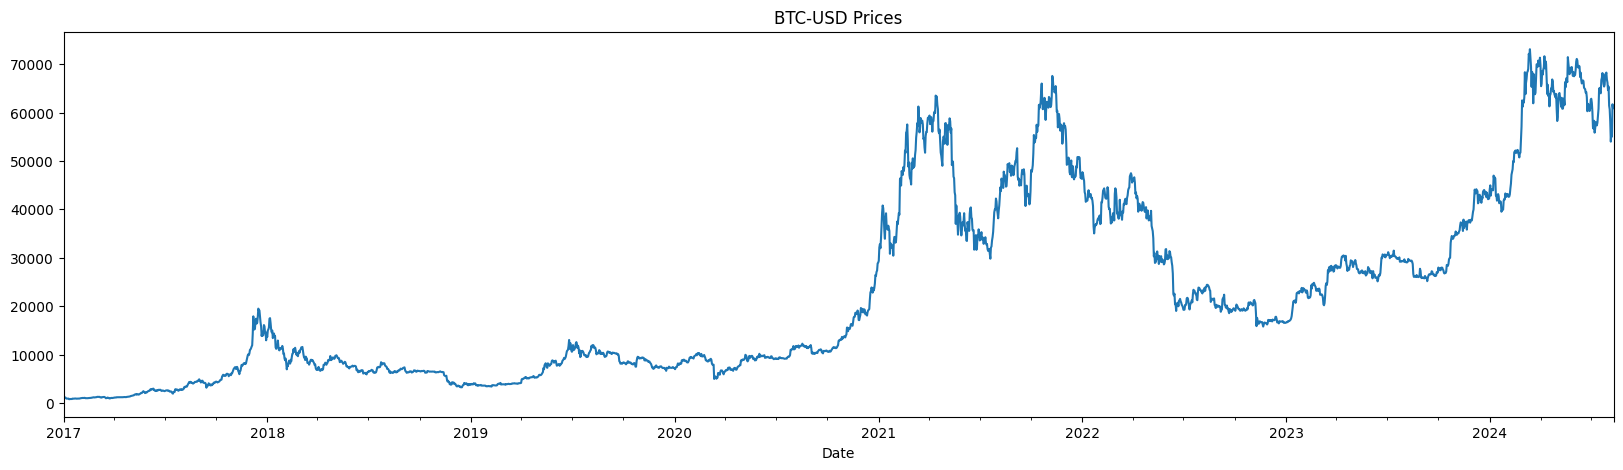

In [41]:
#Graphique
BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.show()

# Preprocessing

In [42]:
BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Dividends','Stock Splits','Volume'])

Standardisation effectuée


# Make Dataset

In [43]:
X_train,X_test,y_train,y_test= make_dataset(data = BTC_USD_historical_array,pas_temps=2,test_size=0.3)

Séparation des données effectuée:
X_train shape : (1942, 2, 1)
X_test shape : (831, 2, 1)
y_train shape: (1942,)
y_test shape: (831,)


### Visualisation

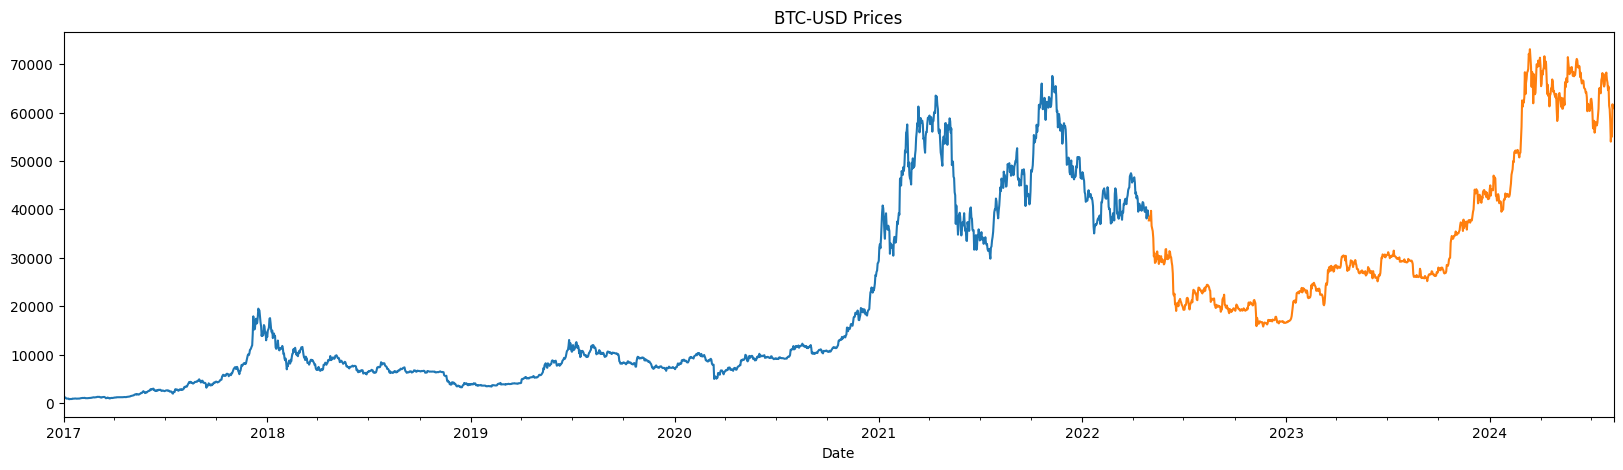

In [44]:
test_size=0.3
size = int(len(BTC_USD_historical)*(1-test_size))

#Tf en df pour la visualisation
train_data_df = BTC_USD_historical[:size]
test_data_df = BTC_USD_historical[size:]

#création d'un tableau d'index temporels
train_index = train_data_df.index
test_index = test_data_df.index

train_data_df.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
test_data_df.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.show()

## Essais

In [89]:
pas_temps = 3
neurons = 250

#Teléchargement via l'API yfinance
BTC_USD = yf.Ticker("BTC-USD")
BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Dividends','Stock Splits','Volume'])

X_train,X_test,y_train,y_test= make_dataset(data = BTC_USD_historical_array, pas_temps=pas_temps, test_size=0.3)

#training
history, duration_seconds,model = train_LSTM_model(X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test, batch_size = 10, neurons = neurons, pas_temps = pas_temps)

#prediction
train_predict_valeurs_reelles, y_train_valeurs_reelles, test_predict_valeurs_reelles,y_test_valeurs_reelles = predict(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, scaler=scaler,model=model)

rmse_train, mse_train, mae_train, explained_variance_train, r2_score_train,rmse_test,mse_test,mae_test, explained_variance_test, r2_score_test = evaluate (train_predict_valeurs_reelles = train_predict_valeurs_reelles,
y_train_valeurs_reelles=y_train_valeurs_reelles,
test_predict_valeurs_reelles = test_predict_valeurs_reelles,
y_test_valeurs_reelles = y_test_valeurs_reelles)


Standardisation effectuée
Séparation des données effectuée:
X_train shape : (917, 3, 1)
X_test shape : (391, 3, 1)
y_train shape: (917,)
y_test shape: (391,)


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 3 jour et un nombre de neurones de 250 : 4.323466 secondes
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


## Visualisation des résultats

pas_temps : 3


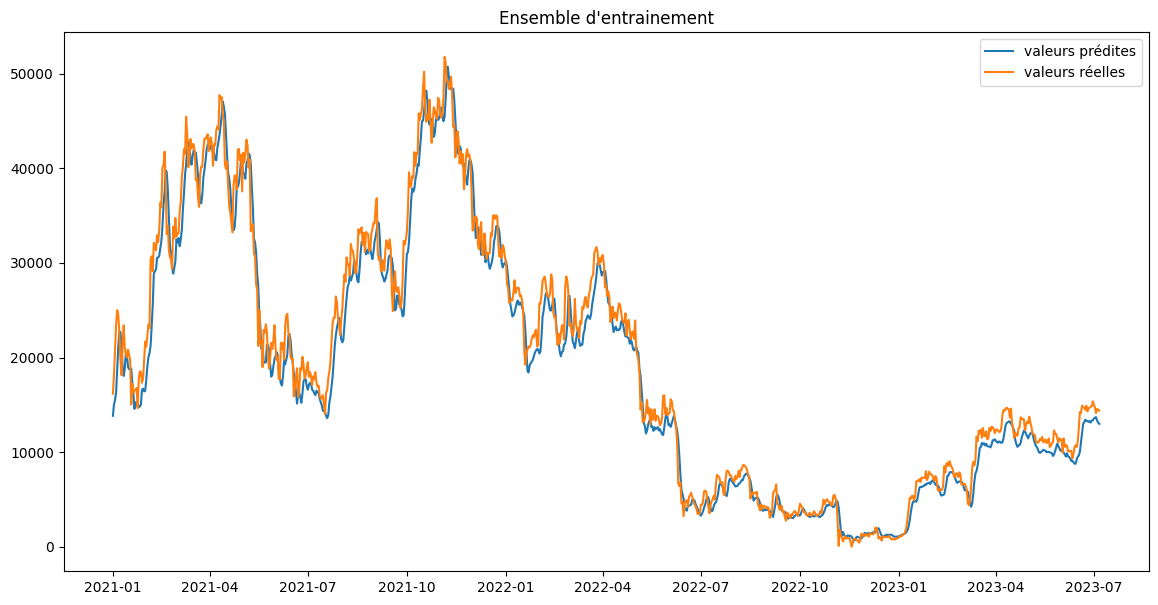

In [97]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(train_index[:-(pas_temps+1)],train_predict_valeurs_reelles,label = "valeurs prédites")
plt.plot(train_index[:-(pas_temps+1)],y_train_valeurs_reelles,label = "valeurs réelles")
plt.title("Ensemble d'entrainement")
plt.legend()
plt.show()

pas_temps : 3


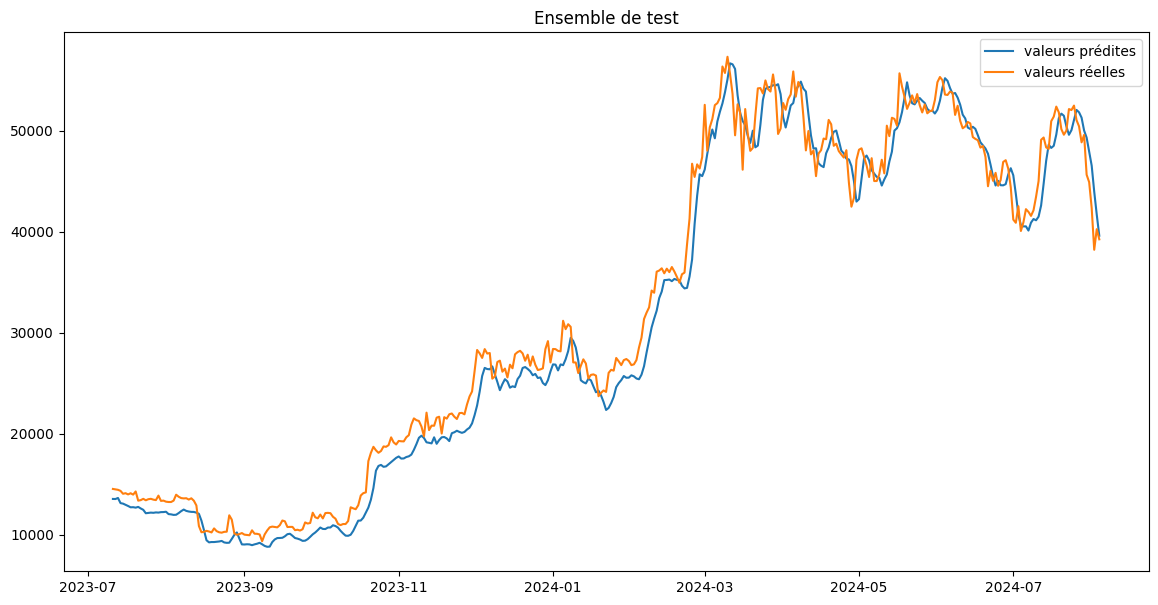

In [102]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[:-(pas_temps+1)],test_predict_valeurs_reelles, label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[:-(pas_temps+1)],y_test_valeurs_reelles, label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()

pas_temps : 3


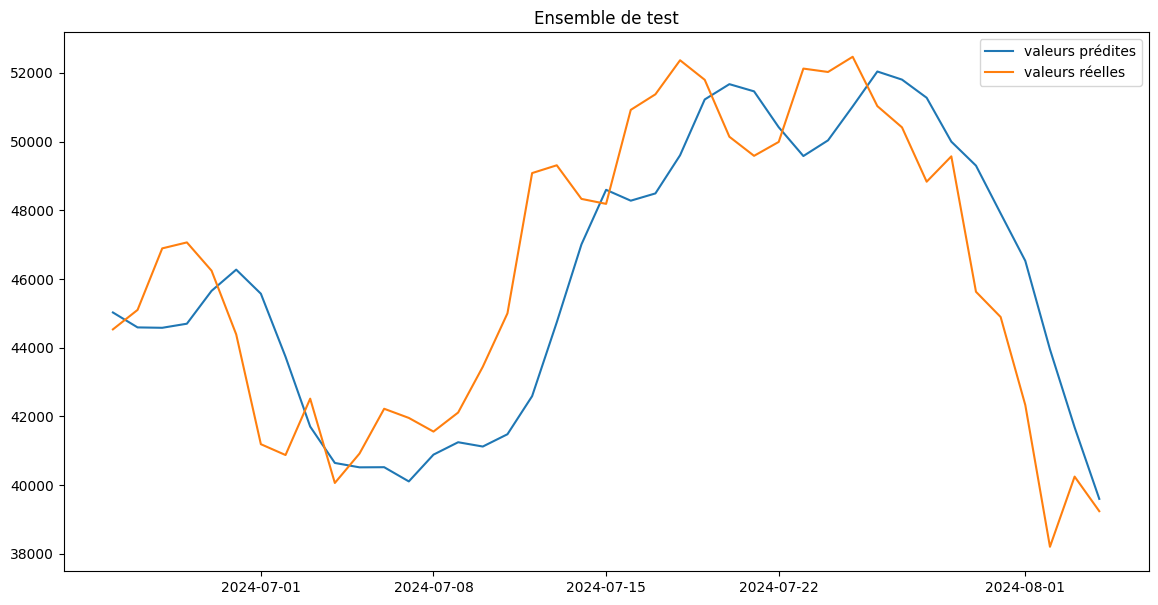

In [98]:
# Visualisation plus fine sur un mois
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[350:-(pas_temps+1)],test_predict_valeurs_reelles[350:], label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[350:-(pas_temps+1)],y_test_valeurs_reelles[350:], label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()

Mettre des % en ordonnnée

## Resultats

In [ ]:
# Optimisation pas_temps

In [70]:
neurons=100

#Création des listes vides
liste_rmse_train = []
liste_mse_train = []
liste_mae_train = []
liste_rmse_test = []
liste_mse_test = []
liste_mae_test = []
liste_explained_variance_train = []
liste_explained_variance_test = []
liste_r2_score_train = []
liste_r2_score_test= []
liste_duration = []


for pas_temps in range(1,20,1):
    
    #Teléchargement via l'API yfinance
    BTC_USD = yf.Ticker("BTC-USD")
    BTC_USD_historical = BTC_USD.history(start="2017-01-01", end="2024-08-11", interval="1d", auto_adjust = True)
    
    BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Dividends','Stock Splits','Volume'])
    
    #Data preparation 
    X_train,X_test,y_train,y_test= make_dataset(data = BTC_USD_historical_array, pas_temps=pas_temps, test_size=0.3)
    print("pas_temps :", pas_temps)
    
    
    #training
    history, duration_seconds,model = train_LSTM_model(X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test, batch_size = 10, neurons = neurons, pas_temps = pas_temps)

    #prediction
    train_predict_valeurs_reelles, y_train_valeurs_reelles, test_predict_valeurs_reelles,y_test_valeurs_reelles = predict(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, scaler=scaler,model=model)

    rmse_train, mse_train, mae_train, explained_variance_train, r2_score_train,rmse_test,mse_test,mae_test, explained_variance_test, r2_score_test = evaluate (train_predict_valeurs_reelles = train_predict_valeurs_reelles,
    y_train_valeurs_reelles=y_train_valeurs_reelles,
    test_predict_valeurs_reelles = test_predict_valeurs_reelles,
    y_test_valeurs_reelles = y_test_valeurs_reelles)

    liste_rmse_train.append(rmse_train)    
    liste_mse_train.append(mse_train)
    liste_mae_train.append(mae_train)
    liste_explained_variance_train.append(explained_variance_train)
    liste_r2_score_train.append(r2_score_train)
    
    liste_rmse_test.append(rmse_test)    
    liste_mse_test.append(mse_test)
    liste_mae_test.append(mae_test)
    liste_explained_variance_test.append(explained_variance_test)
    liste_r2_score_test.append(r2_score_test)  
    

Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 100 : 3.385273 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1942, 2, 1)
X_test shape : (831, 2, 1)
y_train shape: (1942,)
y_test shape: (831,)
pas_temps : 2


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 6: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 2 jour et un nombre de neurones de 100 : 3.669317 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1941, 3, 1)
X_test shape : (830, 3, 1)
y_train shape: (1941,)
y_test shape: (830,)
pas_temps : 3


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 6: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 3 jour et un nombre de neurones de 100 : 3.857445 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1940, 4, 1)
X_test shape : (829, 4, 1)
y_train shape: (1940,)
y_test shape: (829,)
pas_temps : 4


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 4 jour et un nombre de neurones de 100 : 3.685336 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1939, 5, 1)
X_test shape : (828, 5, 1)
y_train shape: (1939,)
y_test shape: (828,)
pas_temps : 5


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 6: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 5 jour et un nombre de neurones de 100 : 5.295888 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1938, 6, 1)
X_test shape : (827, 6, 1)
y_train shape: (1938,)
y_test shape: (827,)
pas_temps : 6


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 6 jour et un nombre de neurones de 100 : 4.735912 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1937, 7, 1)
X_test shape : (826, 7, 1)
y_train shape: (1937,)
y_test shape: (826,)
pas_temps : 7


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 7 jour et un nombre de neurones de 100 : 5.006399 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1936, 8, 1)
X_test shape : (825, 8, 1)
y_train shape: (1936,)
y_test shape: (825,)
pas_temps : 8


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 8: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 8 jour et un nombre de neurones de 100 : 5.222896 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1935, 9, 1)
X_test shape : (824, 9, 1)
y_train shape: (1935,)
y_test shape: (824,)
pas_temps : 9


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 9 jour et un nombre de neurones de 100 : 5.463739 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1934, 10, 1)
X_test shape : (823, 10, 1)
y_train shape: (1934,)
y_test shape: (823,)
pas_temps : 10


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 10 jour et un nombre de neurones de 100 : 5.723377 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1933, 11, 1)
X_test shape : (822, 11, 1)
y_train shape: (1933,)
y_test shape: (822,)
pas_temps : 11


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 11 jour et un nombre de neurones de 100 : 6.031681 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1932, 12, 1)
X_test shape : (821, 12, 1)
y_train shape: (1932,)
y_test shape: (821,)
pas_temps : 12


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 12 jour et un nombre de neurones de 100 : 6.268343 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1931, 13, 1)
X_test shape : (820, 13, 1)
y_train shape: (1931,)
y_test shape: (820,)
pas_temps : 13


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 13 jour et un nombre de neurones de 100 : 6.49994 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1930, 14, 1)
X_test shape : (819, 14, 1)
y_train shape: (1930,)
y_test shape: (819,)
pas_temps : 14


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 14 jour et un nombre de neurones de 100 : 5.821084 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1929, 15, 1)
X_test shape : (818, 15, 1)
y_train shape: (1929,)
y_test shape: (818,)
pas_temps : 15


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 15 jour et un nombre de neurones de 100 : 7.020789 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1928, 16, 1)
X_test shape : (817, 16, 1)
y_train shape: (1928,)
y_test shape: (817,)
pas_temps : 16


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 16 jour et un nombre de neurones de 100 : 7.286593 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1927, 17, 1)
X_test shape : (816, 17, 1)
y_train shape: (1927,)
y_test shape: (816,)
pas_temps : 17


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 17 jour et un nombre de neurones de 100 : 7.573043 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1926, 18, 1)
X_test shape : (815, 18, 1)
y_train shape: (1926,)
y_test shape: (815,)
pas_temps : 18


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 18 jour et un nombre de neurones de 100 : 7.862797 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1925, 19, 1)
X_test shape : (814, 19, 1)
y_train shape: (1925,)
y_test shape: (814,)
pas_temps : 19


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 19 jour et un nombre de neurones de 100 : 8.116718 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/tmp/ipykernel_2440/2981918731.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/tmp/ipykernel_2440/2981918731.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/tmp/ipykernel_2440/2981918731.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend()


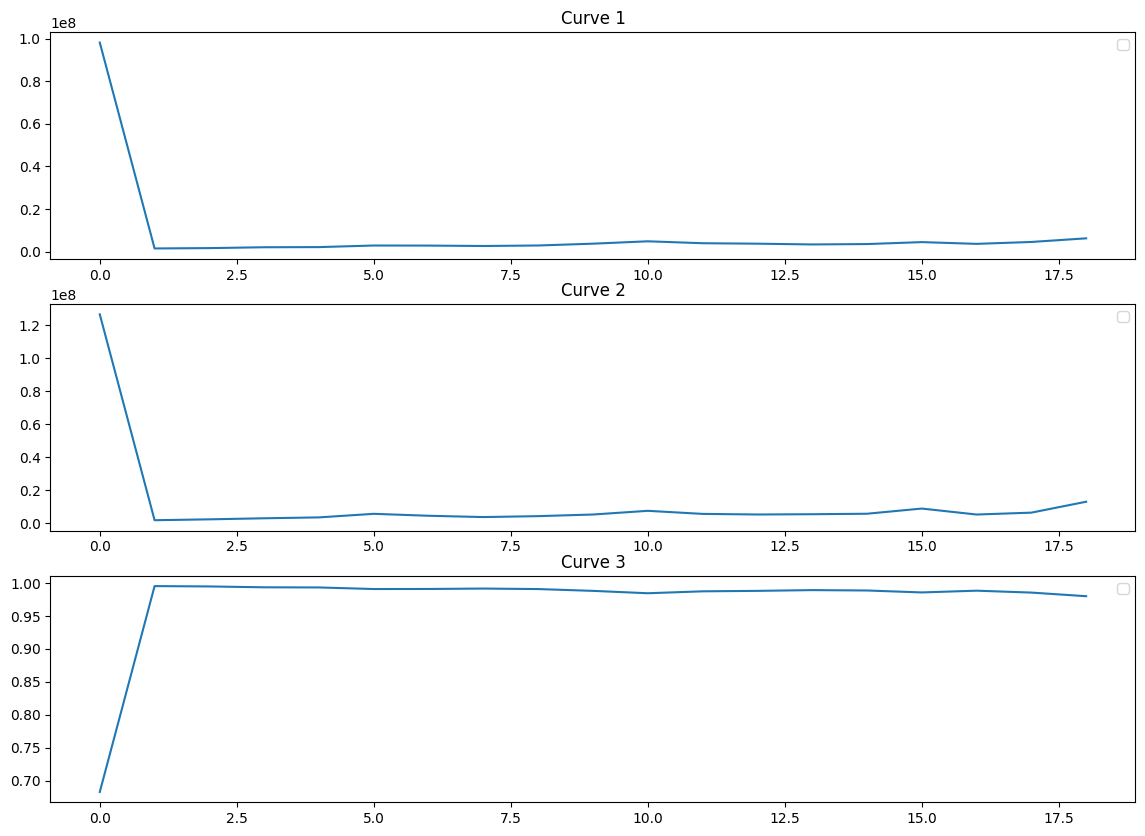

In [71]:
# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 10))

# Plot the first curve on the first subplot
axs[0].plot(liste_mse_train)
axs[0].set_title('Curve 1')

# Plot the second curve on the second subplot
axs[1].plot(liste_mse_test)
axs[1].set_title('Curve 2')

# Plot the third curve on the second subplot
axs[2].plot(liste_r2_score_train)
axs[2].set_title('Curve 3')

# Add a legend to each subplot
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Show the plot
plt.show()



Valeur optimale semble p = 2 par rapport aux métriques

## Optimisation nb neurons

In [65]:
pas_temps=1

#Création des listes vides
liste_rmse_train = []
liste_mse_train = []
liste_mae_train = []
liste_rmse_test = []
liste_mse_test = []
liste_mae_test = []
liste_explained_variance_train = []
liste_explained_variance_test = []
liste_r2_score_train = []
liste_r2_score_test= []
liste_duration = []

for neurons in range(50,500,50):
    
    #Teléchargement via l'API yfinance
    BTC_USD = yf.Ticker("BTC-USD")
    BTC_USD_historical = BTC_USD.history(start="2017-01-01", end="2024-08-11", interval="1d", auto_adjust = True)
    
    BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Dividends','Stock Splits','Volume'])
    
    #Data preparation 
    X_train,X_test,y_train,y_test= make_dataset(data = BTC_USD_historical_array, pas_temps=pas_temps, test_size=0.3)
    print("pas_temps :", pas_temps)
    
    
    #training
    history, duration_seconds,model = train_LSTM_model(X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test, batch_size = 10, neurons = neurons, pas_temps = pas_temps)

    #prediction
    train_predict_valeurs_reelles, y_train_valeurs_reelles, test_predict_valeurs_reelles,y_test_valeurs_reelles = predict(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, scaler=scaler,model=model)

    rmse_train, mse_train, mae_train, explained_variance_train, r2_score_train,rmse_test,mse_test,mae_test, explained_variance_test, r2_score_test = evaluate (train_predict_valeurs_reelles = train_predict_valeurs_reelles,
    y_train_valeurs_reelles=y_train_valeurs_reelles,
    test_predict_valeurs_reelles = test_predict_valeurs_reelles,
    y_test_valeurs_reelles = y_test_valeurs_reelles)

    liste_rmse_train.append(rmse_train)    
    liste_mse_train.append(mse_train)
    liste_mae_train.append(mae_train)
    liste_explained_variance_train.append(explained_variance_train)
    liste_r2_score_train.append(r2_score_train)
    
    liste_rmse_test.append(rmse_test)    
    liste_mse_test.append(mse_test)
    liste_mae_test.append(mae_test)
    liste_explained_variance_test.append(explained_variance_test)
    liste_r2_score_test.append(r2_score_test)     
    

Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 8: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 50 : 3.315397 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 100 : 3.267336 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 150 : 3.699969 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 200 : 4.560754 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 250 : 5.1951 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 300 : 5.978413 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 350 : 7.502003 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 400 : 9.325318 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Standardisation effectuée
Séparation des données effectuée:
X_train shape : (1943, 1, 1)
X_test shape : (832, 1, 1)
y_train shape: (1943,)
y_test shape: (832,)
pas_temps : 1


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 7: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 1.
Temps passé pour un pas de temps de 1 jour et un nombre de neurones de 450 : 11.744799 secondes
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/tmp/ipykernel_2440/2071737667.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/tmp/ipykernel_2440/2071737667.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/tmp/ipykernel_2440/2071737667.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend()


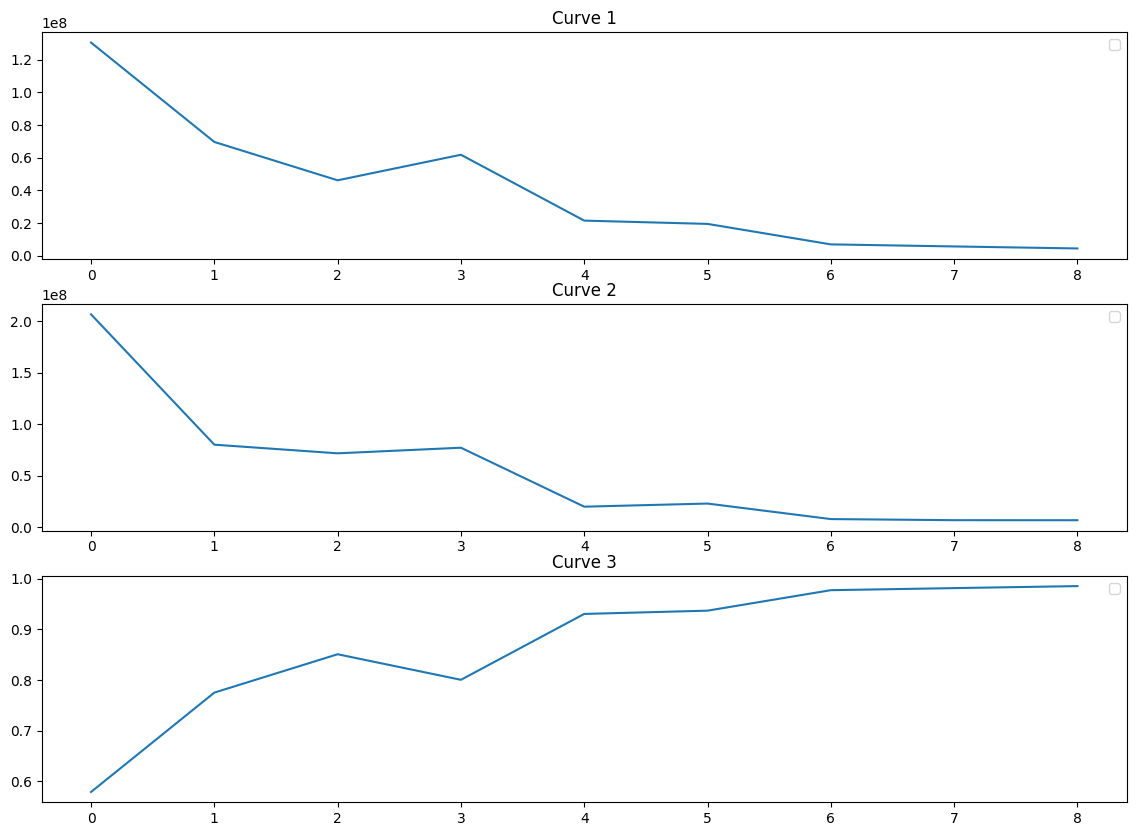

In [66]:
# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 10))

# Plot the first curve on the first subplot
axs[0].plot(liste_mse_train)
axs[0].set_title('Curve 1')

# Plot the second curve on the second subplot
axs[1].plot(liste_mse_test)
axs[1].set_title('Curve 2')

# Plot the third curve on the second subplot
axs[2].plot(liste_r2_score_train)
axs[2].set_title('Curve 3')

# Add a legend to each subplot
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Show the plot
plt.show()


In [ ]:
# 350 neurons semblen le meilleur compris

 # tests Manuels

In [112]:
# Meilleurs hyperparamètres

pas_temps = 2
neurons = 350

#Teléchargement via l'API yfinance
BTC_USD = yf.Ticker("BTC-USD")
BTC_USD_historical = BTC_USD.history(start="2021-01-01", end="2024-08-09", interval="1d", auto_adjust = True)

# test_size
test_size=0.3
size = int(len(BTC_USD_historical)*(1-test_size))

#Tf en df pour la visualisation
train_data_df = BTC_USD_historical[:size]
test_data_df = BTC_USD_historical[size:]

#création d'un tableau d'index temporels
train_index = train_data_df.index
test_index = test_data_df.index

#Normalizing
BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Dividends','Stock Splits','Volume'])

#Train and test data split
size = int(len(BTC_USD_historical_array)*(1-test_size))
train_data, test_data = BTC_USD_historical_array[:size,:], BTC_USD_historical_array[size:,:]
    
#Création des ensembles d'entrainement et de la cible en format de séquence:
X_train, y_train = prepare_sequential_data(data=train_data,pas_temps=pas_temps)
X_test, y_test = prepare_sequential_data(data=test_data,pas_temps=pas_temps)

 #mise en forme des données pour le réseau LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)


#construction du model
model = build_lstm_model(neurons=neurons)
    
#entrainement du modèle
history = model.fit(X_train, y_train,
                        batch_size= 10,
                        epochs=100, verbose=1,
                        validation_data = [X_test, y_test],
                        callbacks=[reduce_learning_rate, early_stopping])

#prédiction et remise à l'échelle X
train_predict = model.predict(X_train)
train_predict_valeurs_reelles = train_predict/scaler.scale_[0]


test_predict = model.predict(X_test)
test_predict_valeurs_reelles = test_predict/scaler.scale_[0]

#prédiction et remise à l'échelle y
y_train = y_train.reshape(-1,1)
y_train_valeurs_reelles = y_train /scaler.scale_[0]

y_test = y_test.reshape(-1,1)
y_test_valeurs_reelles = y_test/scaler.scale_[0]

#score train
mse_train = mean_squared_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
mae_train = mean_absolute_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
r2_score_train = r2_score(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    
# score test
mse_test = mean_squared_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
mae_test = mean_absolute_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
r2_score_test = r2_score(y_test_valeurs_reelles,test_predict_valeurs_reelles)

print("mse train :", mse_train)
print("mae train :", mae_train)
print("r2_score_train :", r2_score_train)
print("mse test :", mse_test)
print("mae train :", mae_test)
print("r2_score_test :", r2_score_test)

Standardisation effectuée
Epoch 1/100


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0689 - mse: 0.0689 - val_loss: 8.1634e-04 - val_mse: 8.1634e-04 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9802e-04 - mse: 8.9802e-04 - val_loss: 9.8156e-04 - val_mse: 9.8156e-04 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9057e-04 - mse: 8.9057e-04 - val_loss: 0.0012 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3429e-04 - mse: 9.3429e-04 - val_loss: 9.4939e-04 - val_mse: 9.4939e-04 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9342e-04 - mse: 7.9342e-04 - val_loss: 9.4847e-04 - val_mse: 9.4847e-04 - learning_rate: 0.0010
Epoch 6/100
85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2878e-04 - mse: 9.2878e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 1e-06.
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2000e-04 - mse: 9.2000e-04 - val_loss: 0.0012 

pas_temps : 2


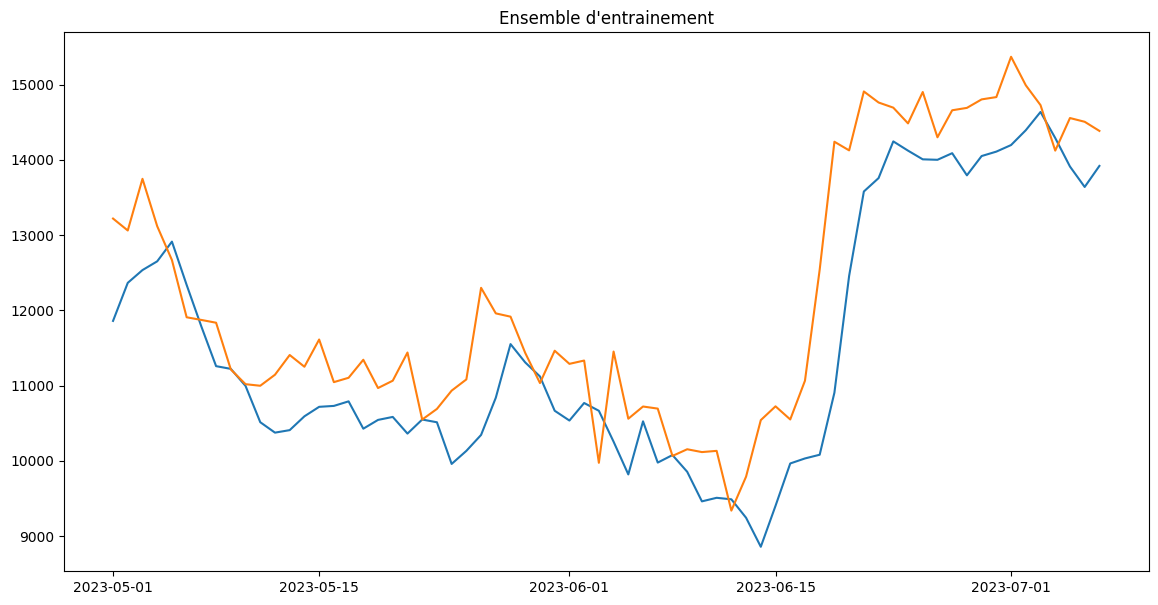

In [113]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(train_index[850:-(pas_temps+1)],train_predict_valeurs_reelles[850:], label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(train_index[850:-(pas_temps+1)],y_train_valeurs_reelles[850:], label = "valeurs réelles")
plt.title("Ensemble d'entrainement")
plt.show()

pas_temps : 2


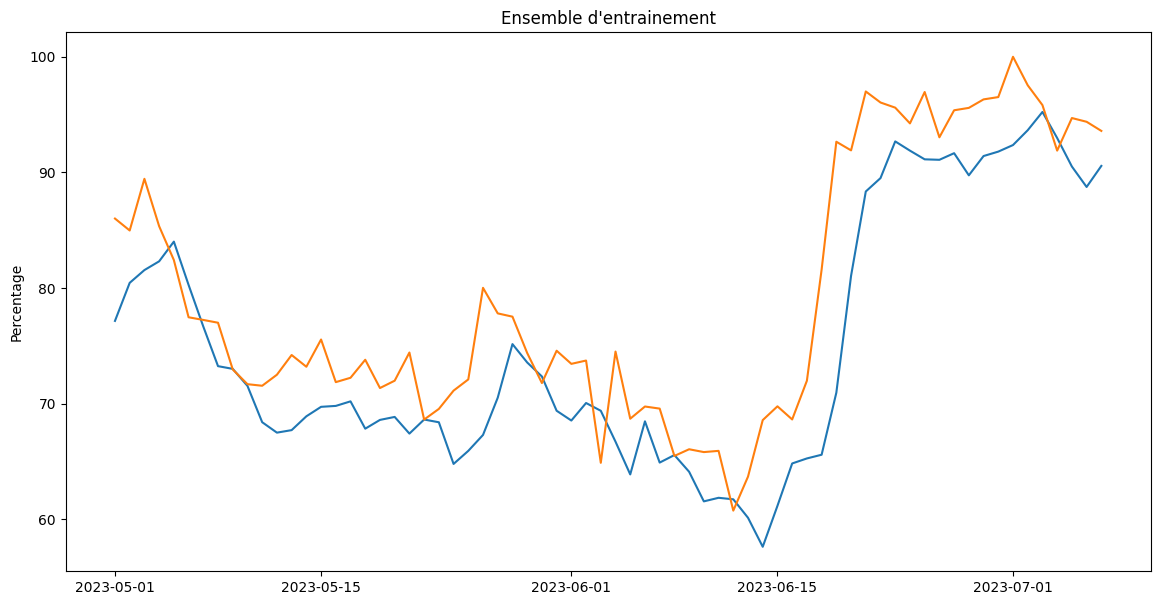

In [118]:
# Normalize the data
max_value = max(max(train_predict_valeurs_reelles[850:]), max(y_train_valeurs_reelles[850:]))
train_predict_valeurs_reelles_normalized = [(value / max_value) * 100 for value in train_predict_valeurs_reelles[850:]]
y_train_valeurs_reelles_normalized = [(value / max_value) * 100 for value in y_train_valeurs_reelles[850:]]

# Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(train_index[850:-(pas_temps+1)], train_predict_valeurs_reelles_normalized, label = "valeurs prédites")
plt.plot(train_index[850:-(pas_temps+1)], y_train_valeurs_reelles_normalized, label = "valeurs réelles")
plt.ylabel('Percentage')
plt.title("Ensemble d'entrainement")
plt.show()

pas_temps : 2


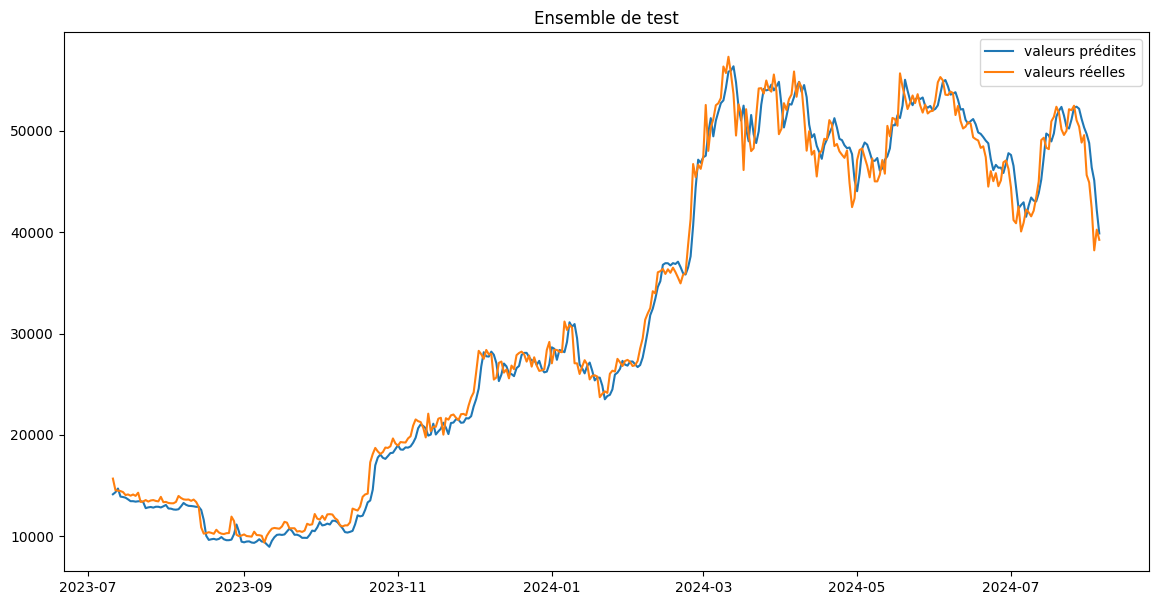

In [115]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[:-(pas_temps+1)],test_predict_valeurs_reelles, label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[:-(pas_temps+1)],y_test_valeurs_reelles, label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()

In [108]:
# En gardant la colonne Volume

pas_temps = 2
neurons = 350

#Teléchargement via l'API yfinance
BTC_USD = yf.Ticker("BTC-USD")
BTC_USD_historical = BTC_USD.history(start="2021-01-01", end="2024-08-09", interval="1d", auto_adjust = True)

# test_size
test_size=0.3
size = int(len(BTC_USD_historical)*(1-test_size))

#Tf en df pour la visualisation
train_data_df = BTC_USD_historical[:size]
test_data_df = BTC_USD_historical[size:]

#création d'un tableau d'index temporels
train_index = train_data_df.index
test_index = test_data_df.index

#Normalizing
BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Dividends','Stock Splits'])

#Train and test data split
size = int(len(BTC_USD_historical_array)*(1-test_size))
train_data, test_data = BTC_USD_historical_array[:size,:], BTC_USD_historical_array[size:,:]
    
#Création des ensembles d'entrainement et de la cible en format de séquence:
X_train, y_train = prepare_sequential_data(data=train_data,pas_temps=pas_temps)
X_test, y_test = prepare_sequential_data(data=test_data,pas_temps=pas_temps)

 #mise en forme des données pour le réseau LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)


#construction du model
model = build_lstm_model(neurons=neurons)
    
#entrainement du modèle
history = model.fit(X_train, y_train,
                        batch_size= 10,
                        epochs=100, verbose=1,
                        validation_data = [X_test, y_test],
                        callbacks=[reduce_learning_rate, early_stopping])

#prédiction et remise à l'échelle X
train_predict = model.predict(X_train)
train_predict_valeurs_reelles = train_predict/scaler.scale_[0]


test_predict = model.predict(X_test)
test_predict_valeurs_reelles = test_predict/scaler.scale_[0]

#prédiction et remise à l'échelle y
y_train = y_train.reshape(-1,1)
y_train_valeurs_reelles = y_train /scaler.scale_[0]

y_test = y_test.reshape(-1,1)
y_test_valeurs_reelles = y_test/scaler.scale_[0]

#score train
mse_train = mean_squared_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
mae_train = mean_absolute_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
r2_score_train = r2_score(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    
# score test
mse_test = mean_squared_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
mae_test = mean_absolute_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
r2_score_test = r2_score(y_test_valeurs_reelles,test_predict_valeurs_reelles)

print("mse train :", mse_train)
print("mae train :", mae_train)
print("r2_score_train :", r2_score_train)
print("mse test :", mse_test)
print("mae train :", mae_test)
print("r2_score_test :", r2_score_test)

Standardisation effectuée
Epoch 1/100


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0754 - mse: 0.0754 - val_loss: 9.0708e-04 - val_mse: 9.0708e-04 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8083e-04 - mse: 8.8083e-04 - val_loss: 7.3298e-04 - val_mse: 7.3298e-04 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8565e-04 - mse: 8.8565e-04 - val_loss: 8.8716e-04 - val_mse: 8.8716e-04 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7649e-04 - mse: 7.7649e-04 - val_loss: 0.0014 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5178e-04 - mse: 9.5178e-04 - val_loss: 8.1546e-04 - val_mse: 8.1546e-04 - learning_rate: 0.0010
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5272e-04 - mse: 8.5272e-04 - val_loss: 7.7176e-04 - val_mse: 7.7176e-04 - learning_rate: 0.0010
Epoch 7/100
83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8405e-04 - mse: 9.8405e-0

pas_temps : 2


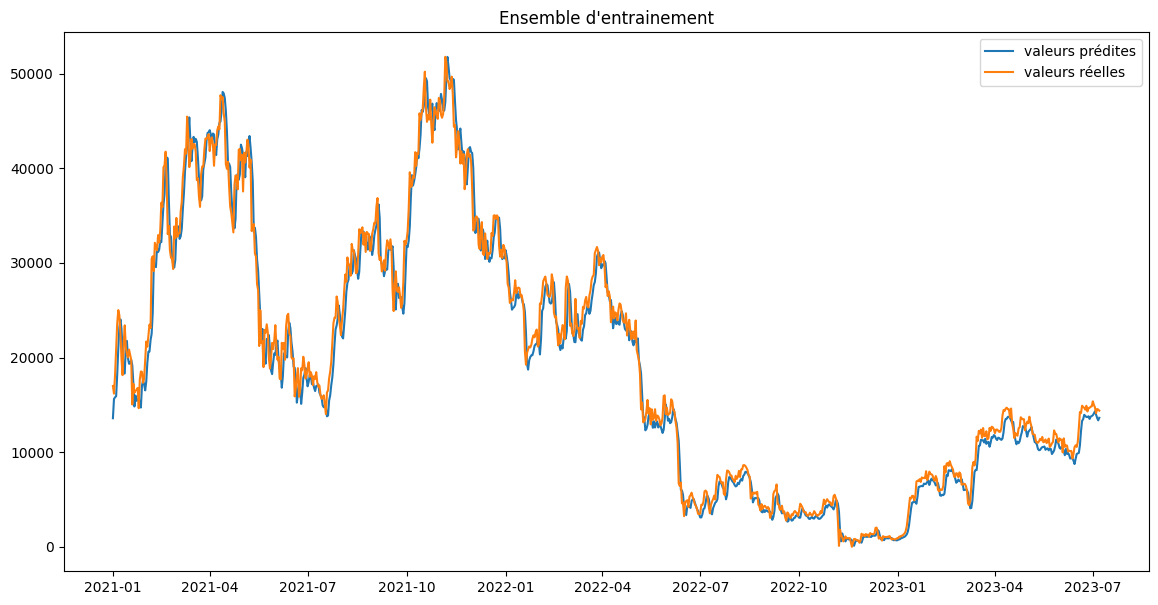

In [109]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(train_index[:-(pas_temps+1)],train_predict_valeurs_reelles,label = "valeurs prédites")
plt.plot(train_index[:-(pas_temps+1)],y_train_valeurs_reelles,label = "valeurs réelles")
plt.title("Ensemble d'entrainement")
plt.legend()
plt.show()

pas_temps : 2


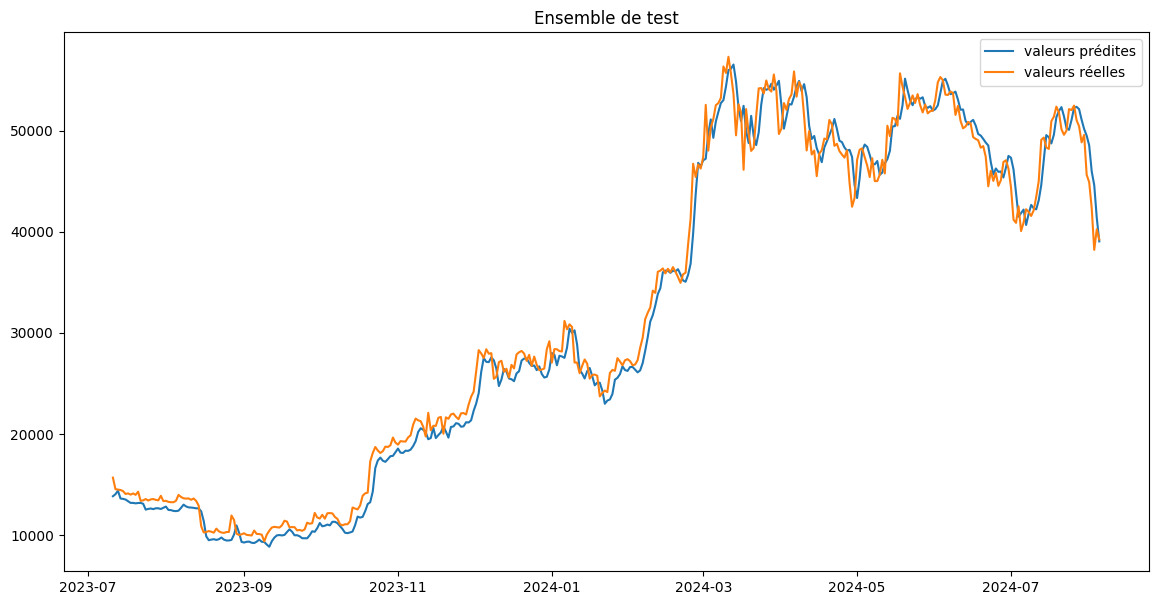

In [110]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[:-(pas_temps+1)],test_predict_valeurs_reelles, label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[:-(pas_temps+1)],y_test_valeurs_reelles, label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()

pas_temps : 2


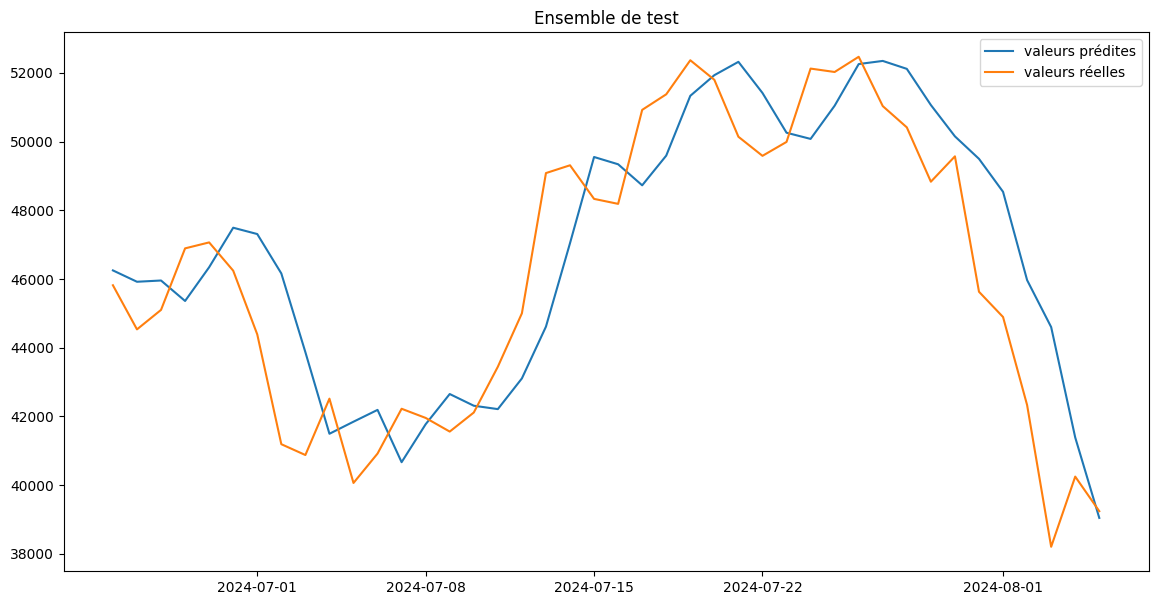

In [111]:
# Visualisation plus fine sur un mois
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[350:-(pas_temps+1)],test_predict_valeurs_reelles[350:], label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[350:-(pas_temps+1)],y_test_valeurs_reelles[350:], label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()

In [124]:
#AVec le BTC-EUR

# Meilleurs hyperparamètres

pas_temps = 2
neurons = 350

#Teléchargement via l'API yfinance
BTC_USD = yf.Ticker("BTC-EUR")
BTC_USD_historical = BTC_USD.history(start="2021-01-01", end="2024-08-09", interval="1d", auto_adjust = True)

# test_size
test_size=0.3
size = int(len(BTC_USD_historical)*(1-test_size))

#Tf en df pour la visualisation
train_data_df = BTC_USD_historical[:size]
test_data_df = BTC_USD_historical[size:]

#création d'un tableau d'index temporels
train_index = train_data_df.index
test_index = test_data_df.index

#Normalizing
BTC_USD_historical_array, BTC_USD_historical.index, scaler,step = normalize_data(df= BTC_USD_historical, columns=['Open','High','Low','Dividends','Stock Splits','Volume'])

#Train and test data split
size = int(len(BTC_USD_historical_array)*(1-test_size))
train_data, test_data = BTC_USD_historical_array[:size,:], BTC_USD_historical_array[size:,:]
    
#Création des ensembles d'entrainement et de la cible en format de séquence:
X_train, y_train = prepare_sequential_data(data=train_data,pas_temps=pas_temps)
X_test, y_test = prepare_sequential_data(data=test_data,pas_temps=pas_temps)

 #mise en forme des données pour le réseau LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)


#construction du model
model = build_lstm_model(neurons=neurons)
    
#entrainement du modèle
history = model.fit(X_train, y_train,
                        batch_size= 10,
                        epochs=100, verbose=1,
                        validation_data = [X_test, y_test],
                        callbacks=[reduce_learning_rate, early_stopping])

#prédiction et remise à l'échelle X
train_predict = model.predict(X_train)
train_predict_valeurs_reelles = train_predict/scaler.scale_[0]


test_predict = model.predict(X_test)
test_predict_valeurs_reelles = test_predict/scaler.scale_[0]

#prédiction et remise à l'échelle y
y_train = y_train.reshape(-1,1)
y_train_valeurs_reelles = y_train /scaler.scale_[0]

y_test = y_test.reshape(-1,1)
y_test_valeurs_reelles = y_test/scaler.scale_[0]

#score train
mse_train = mean_squared_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
mae_train = mean_absolute_error(y_train_valeurs_reelles,train_predict_valeurs_reelles)
r2_score_train = r2_score(y_train_valeurs_reelles,train_predict_valeurs_reelles)
    
# score test
mse_test = mean_squared_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
mae_test = mean_absolute_error(y_test_valeurs_reelles,test_predict_valeurs_reelles)
r2_score_test = r2_score(y_test_valeurs_reelles,test_predict_valeurs_reelles)

print("mse train :", mse_train)
print("mae train :", mae_train)
print("r2_score_train :", r2_score_train)
print("mse test :", mse_test)
print("mae train :", mae_test)
print("r2_score_test :", r2_score_test)

Standardisation effectuée
Epoch 1/100


/home/frederic/kDrive/Data/Code/DataScientest/MainCrypto/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0634 - mse: 0.0634 - val_loss: 0.0011 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3034e-04 - mse: 7.3034e-04 - val_loss: 0.0014 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2415e-04 - mse: 8.2415e-04 - val_loss: 0.0017 - val_mse: 0.0017 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4755e-04 - mse: 7.4755e-04 - val_loss: 0.0012 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3423e-04 - mse: 8.3423e-04 - val_loss: 0.0014 - val_mse: 0.0014 - learning_rate: 0.0010
Epoch 6/100
87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2494e-04 - mse: 8.2494e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 1e-06.
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2414e-04 - mse: 8.2414e-04 - val_loss: 0.0020 - val_mse: 0.0020 - learning_rat

pas_temps : 2


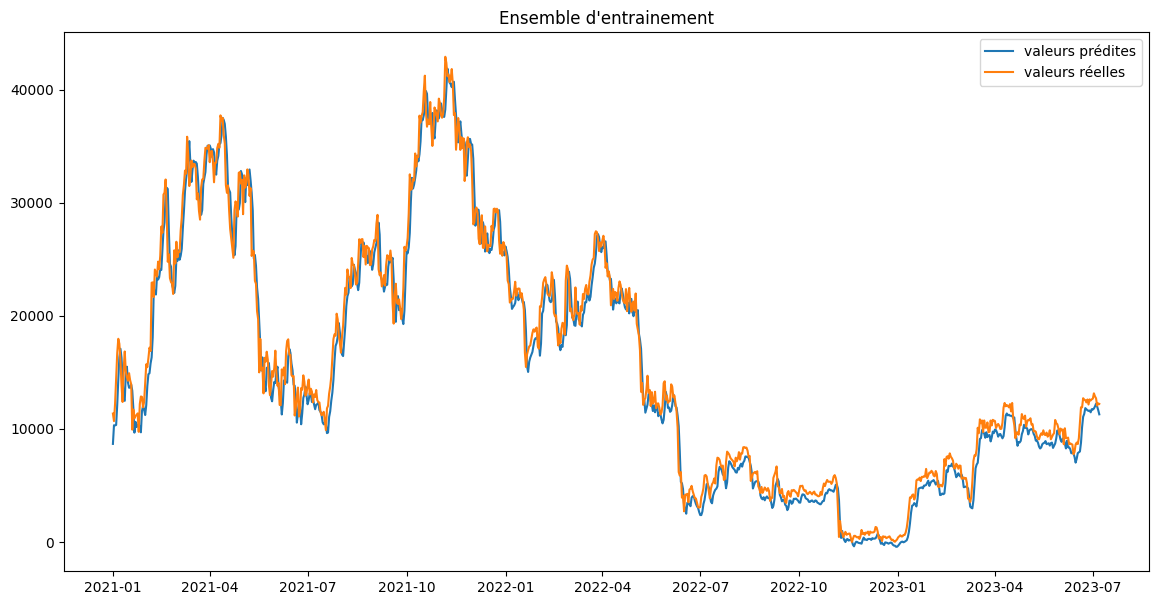

In [125]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(train_index[:-(pas_temps+1)],train_predict_valeurs_reelles,label = "valeurs prédites")
plt.plot(train_index[:-(pas_temps+1)],y_train_valeurs_reelles,label = "valeurs réelles")
plt.title("Ensemble d'entrainement")
plt.legend()
plt.show()

pas_temps : 2


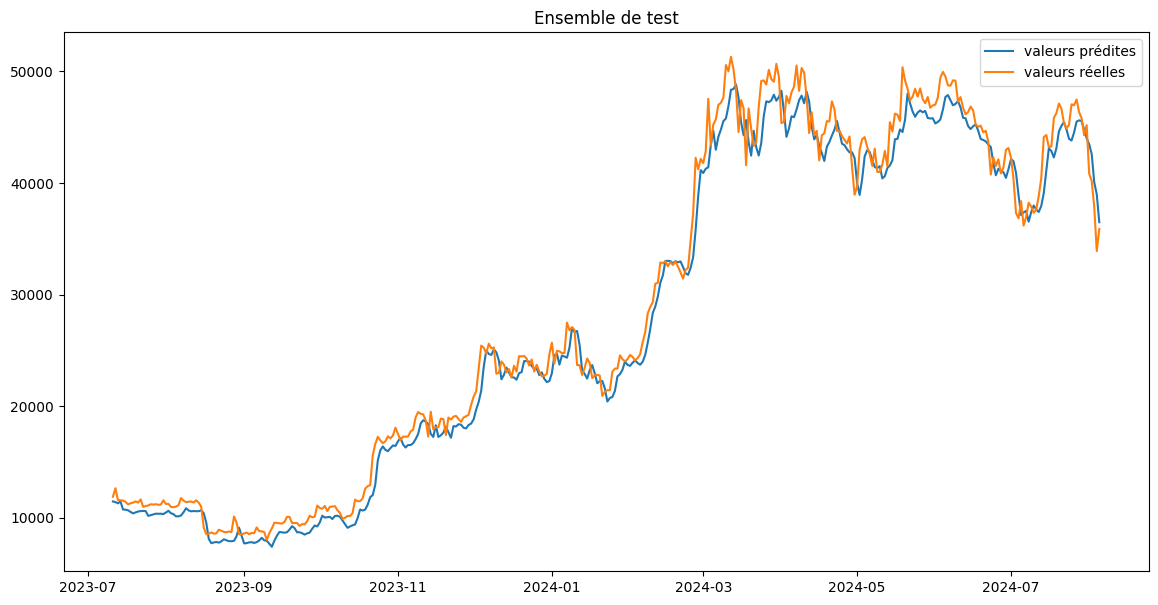

In [126]:
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[:-(pas_temps+1)],test_predict_valeurs_reelles, label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[:-(pas_temps+1)],y_test_valeurs_reelles, label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()

pas_temps : 2


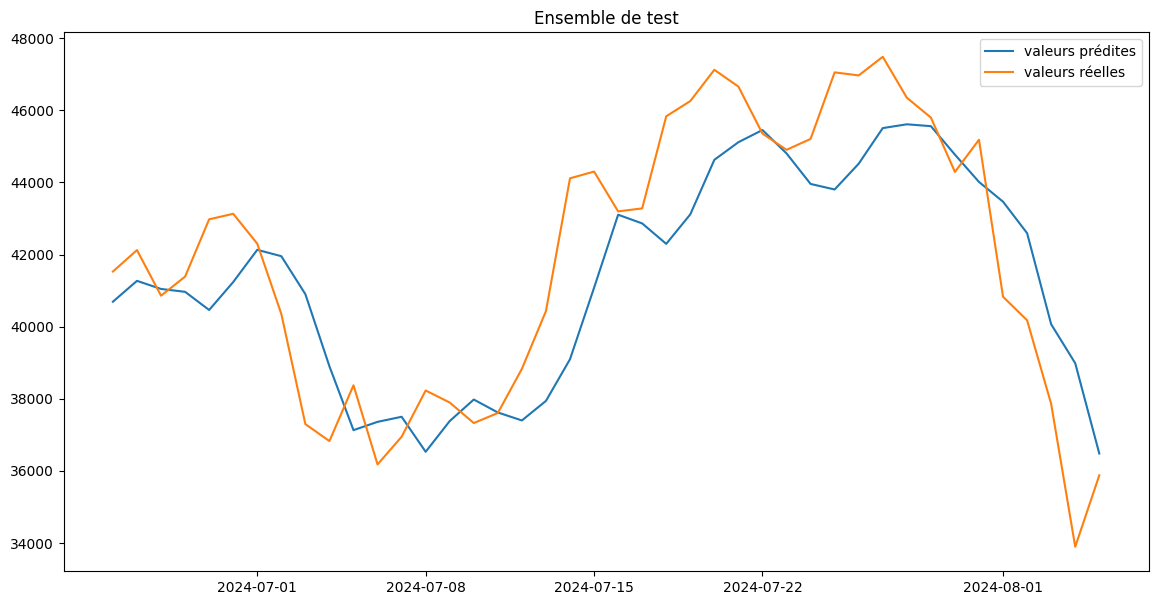

In [127]:
# Visualisation plus fine sur un mois
#Plotting
print("pas_temps :", pas_temps)
plt.figure(figsize=(14,7))
plt.plot(test_index[350:-(pas_temps+1)],test_predict_valeurs_reelles[350:], label = "valeurs prédites")
#BTC_USD_historical.Close.plot(figsize=(20,5), title = "BTC-USD Prices")
plt.plot(test_index[350:-(pas_temps+1)],y_test_valeurs_reelles[350:], label = "valeurs réelles")
plt.title("Ensemble de test")
plt.legend()
plt.show()